In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import zscore, kstest, kurtosis, skew
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
data = pd.read_csv('/content/ParisHousingClass_04.csv')

In [ ]:
# Observando a composição das primeiras 5 linhas do dataset:
data.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,category,priceClass
0,29356,96,1,1,46,4864,4,9,1990,1,1,1780,393,413,1,3,Luxury,low
1,82560,46,0,0,56,25513,4,8,2012,1,1,3950,4525,218,1,4,Basic,very_high
2,13560,1,1,0,17,85418,4,3,2001,1,0,7736,3841,296,1,1,Basic,very_low
3,69246,63,1,0,29,43940,5,3,1995,1,1,4516,5884,154,0,3,Basic,high
4,80699,20,1,0,88,65145,3,10,2009,0,1,1740,1538,372,0,8,Basic,very_high


In [ ]:
# Verificando a presença de valores NA nas colunas:
na_data = data.isna().sum()
na_data

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
category             0
priceClass           0
dtype: int64

In [ ]:
# Verificando a presença de valores NULL nas colunas:
null_data = data.isnull().sum()
null_data

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityCode             0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
category             0
priceClass           0
dtype: int64

In [ ]:
# Informações referentes às 18 colunas:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19280 entries, 0 to 19279
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   squareMeters       19280 non-null  int64 
 1   numberOfRooms      19280 non-null  int64 
 2   hasYard            19280 non-null  int64 
 3   hasPool            19280 non-null  int64 
 4   floors             19280 non-null  int64 
 5   cityCode           19280 non-null  int64 
 6   cityPartRange      19280 non-null  int64 
 7   numPrevOwners      19280 non-null  int64 
 8   made               19280 non-null  int64 
 9   isNewBuilt         19280 non-null  int64 
 10  hasStormProtector  19280 non-null  int64 
 11  basement           19280 non-null  int64 
 12  attic              19280 non-null  int64 
 13  garage             19280 non-null  int64 
 14  hasStorageRoom     19280 non-null  int64 
 15  hasGuestRoom       19280 non-null  int64 
 16  category           19280 non-null  objec

In [ ]:
# Para conseguirmos descobrir quantas classificações únicas e suas distribuições
data['category'].value_counts()

Basic     16861
Luxury     2419
Name: category, dtype: int64

In [ ]:
# Para conseguirmos descobrir quantas classificações únicas e suas distribuições
data['priceClass'].value_counts()

medium       3976
very_low     3856
very_high    3826
low          3811
high         3811
Name: priceClass, dtype: int64

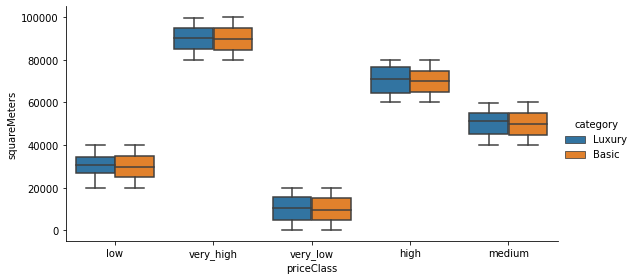

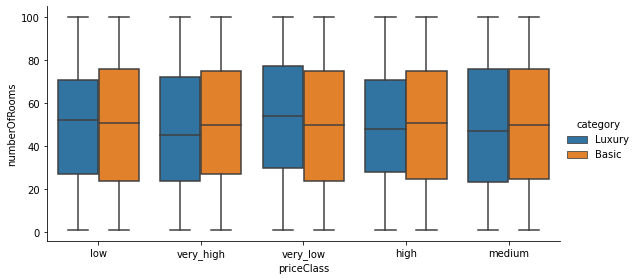

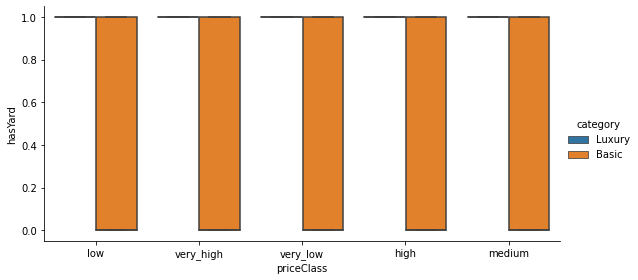

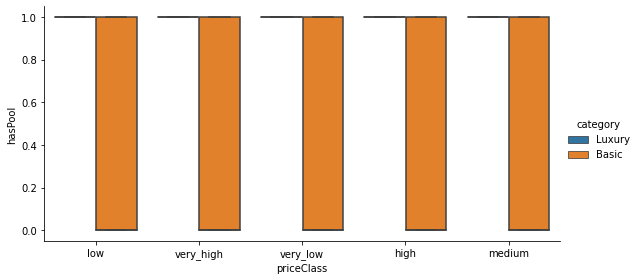

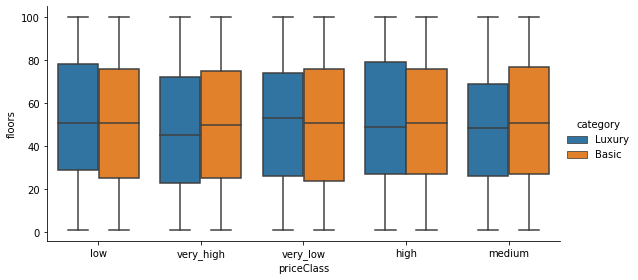

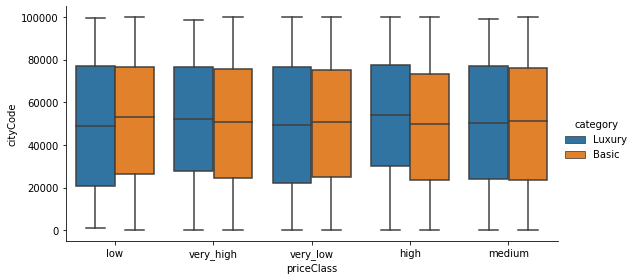

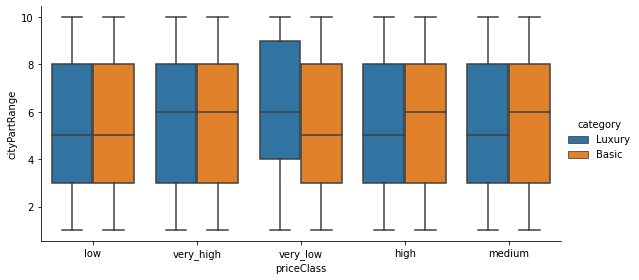

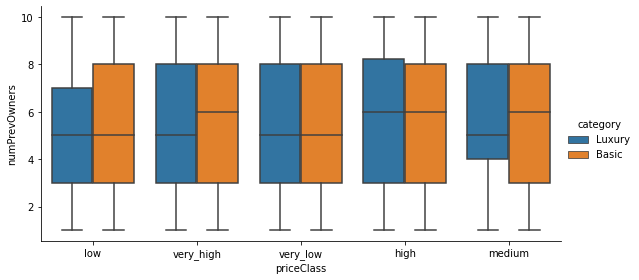

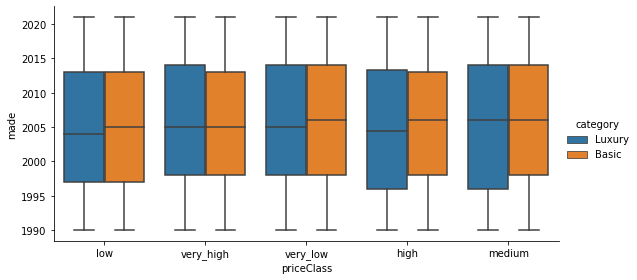

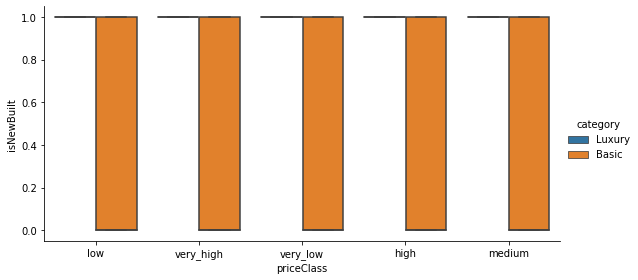

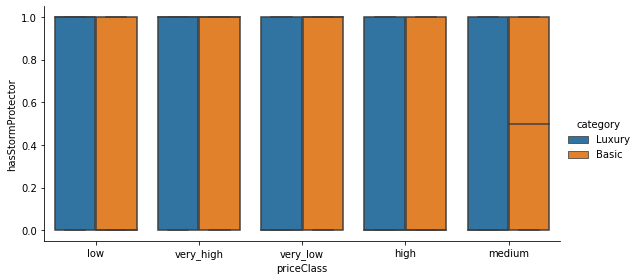

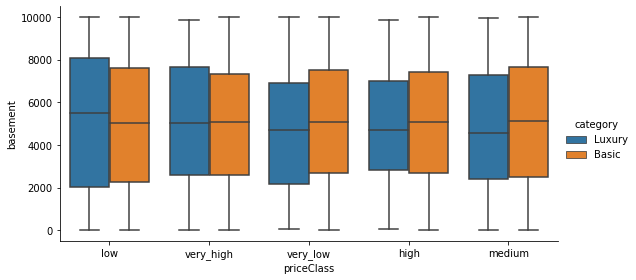

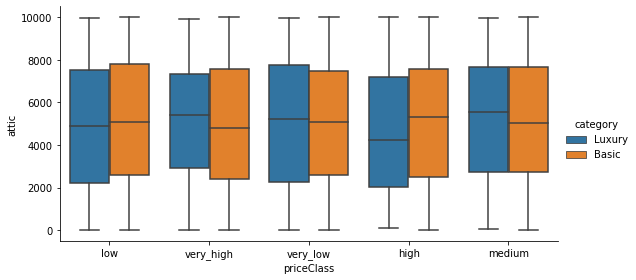

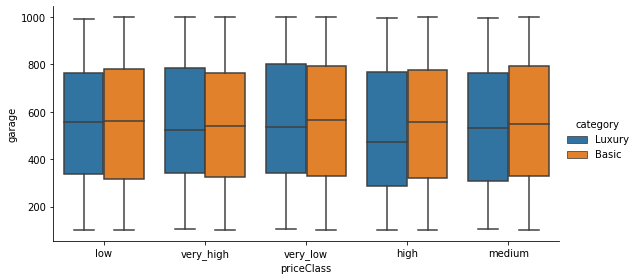

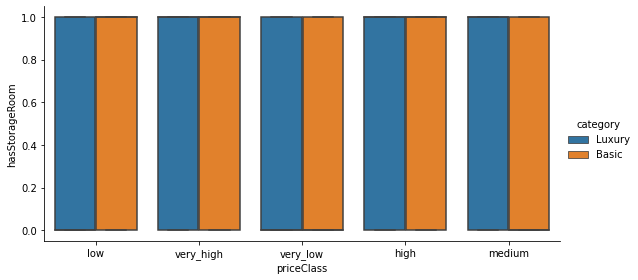

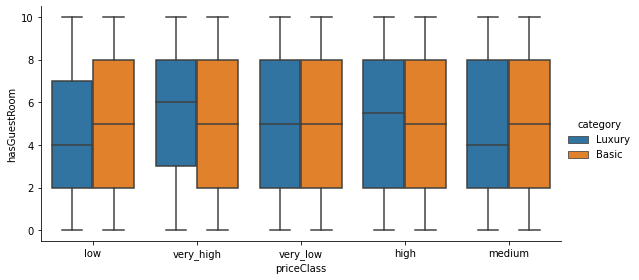

In [ ]:
# Checando possíveis outliers por meio de boxplots
for col in data.columns[:-2]:
    sns.catplot(x="priceClass", y=col,
                data=data,hue='category',
                kind="box", height=4,
                aspect=2)

In [ ]:
# Codificando as variáveis rótulo:
data['category'] = data['category'].replace({'Basic': 0,
                                            'Luxury': 1})
data.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,category,priceClass
0,29356,96,1,1,46,4864,4,9,1990,1,1,1780,393,413,1,3,1,low
1,82560,46,0,0,56,25513,4,8,2012,1,1,3950,4525,218,1,4,0,very_high
2,13560,1,1,0,17,85418,4,3,2001,1,0,7736,3841,296,1,1,0,very_low
3,69246,63,1,0,29,43940,5,3,1995,1,1,4516,5884,154,0,3,0,high
4,80699,20,1,0,88,65145,3,10,2009,0,1,1740,1538,372,0,8,0,very_high


In [ ]:
data['priceClass'] = data['priceClass'].replace({'very_low': 0, 'low': 1,
                                                 'medium': 2, 'high': 3,
                                                 'very_high': 4})
data.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,category,priceClass
0,29356,96,1,1,46,4864,4,9,1990,1,1,1780,393,413,1,3,1,1
1,82560,46,0,0,56,25513,4,8,2012,1,1,3950,4525,218,1,4,0,4
2,13560,1,1,0,17,85418,4,3,2001,1,0,7736,3841,296,1,1,0,0
3,69246,63,1,0,29,43940,5,3,1995,1,1,4516,5884,154,0,3,0,3
4,80699,20,1,0,88,65145,3,10,2009,0,1,1740,1538,372,0,8,0,4


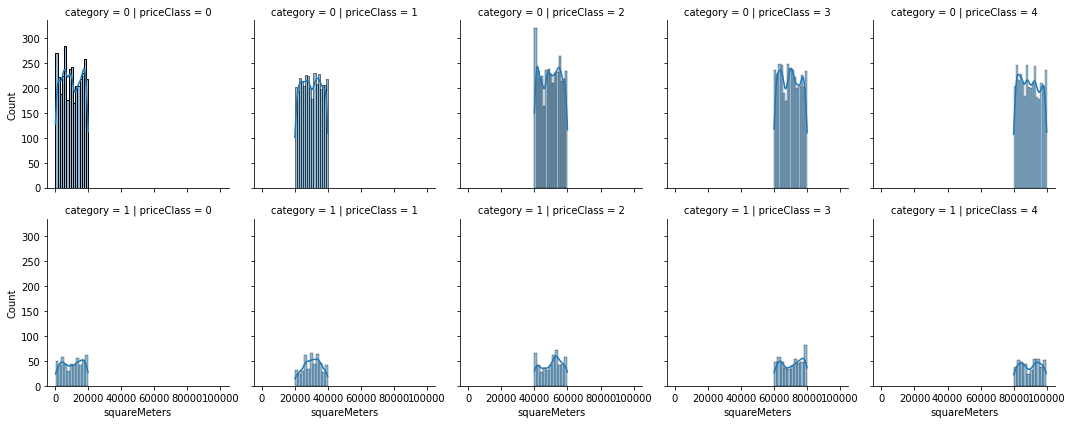

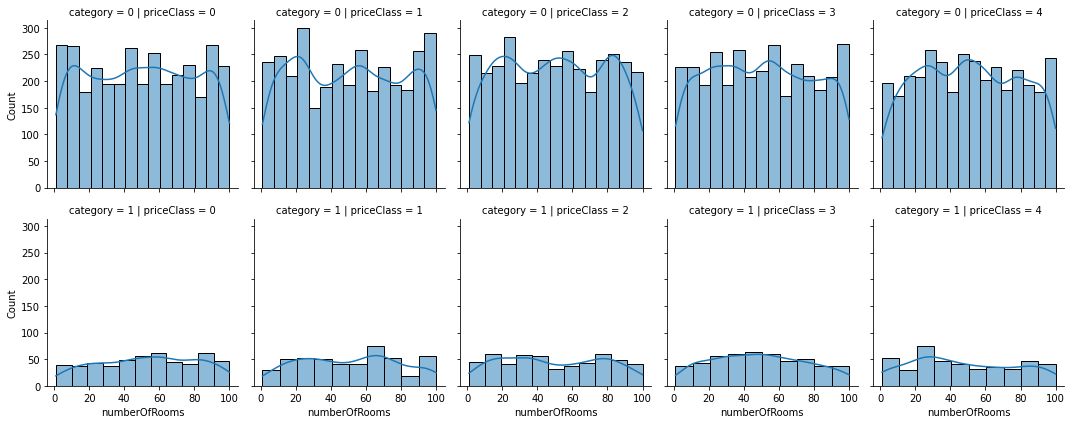

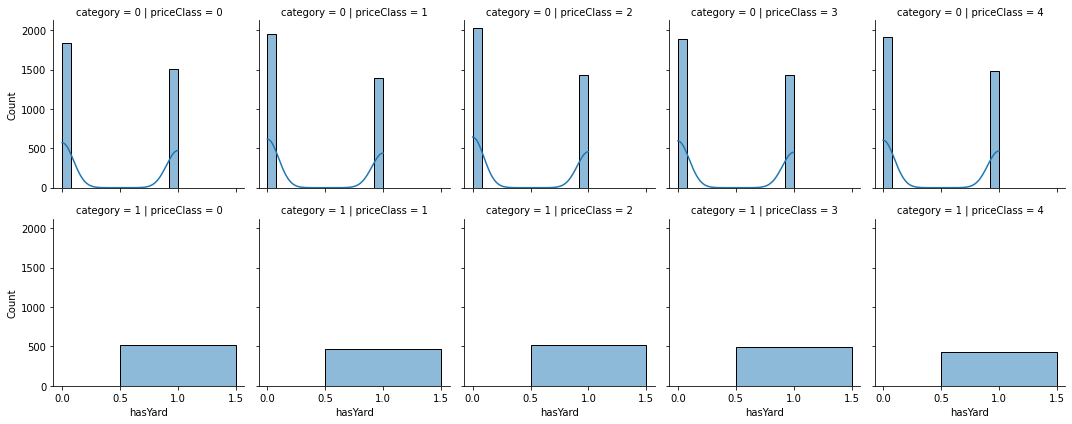

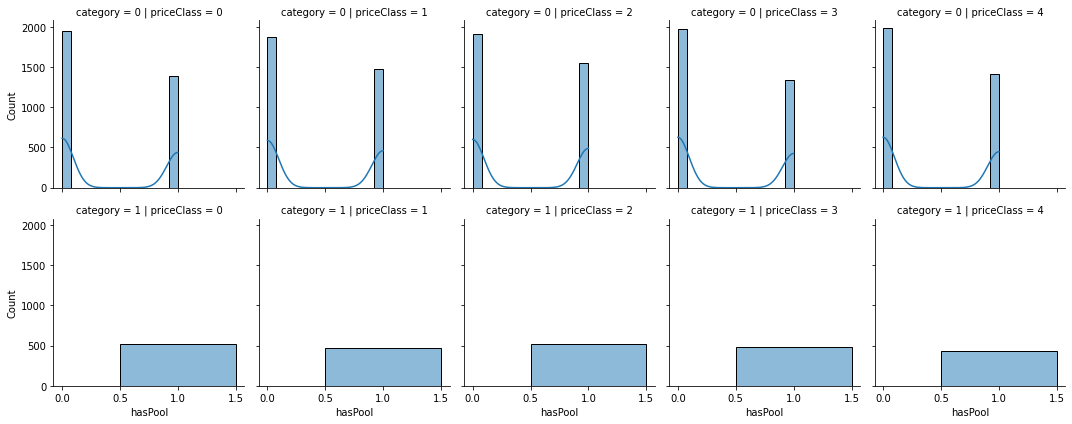

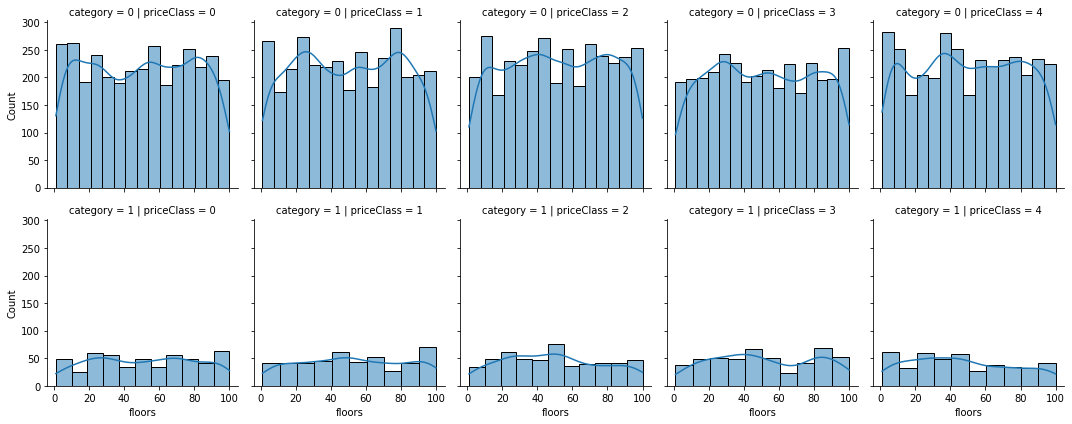

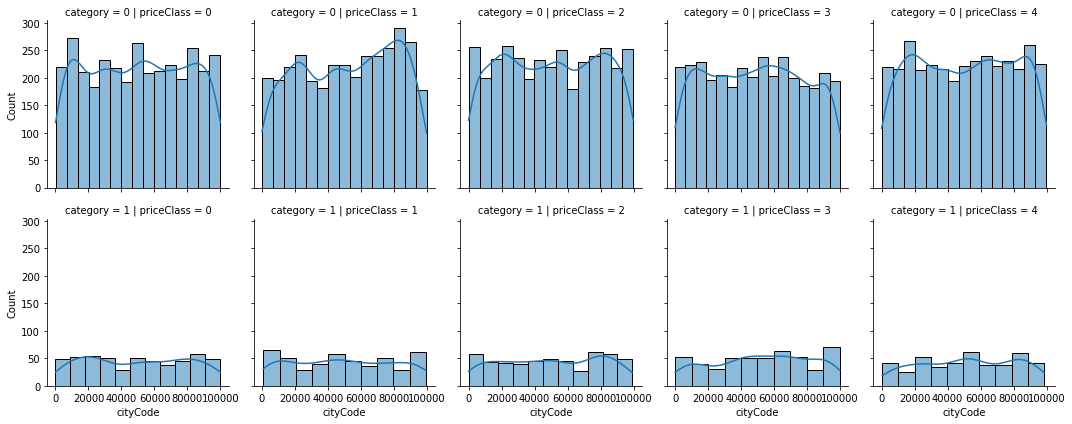

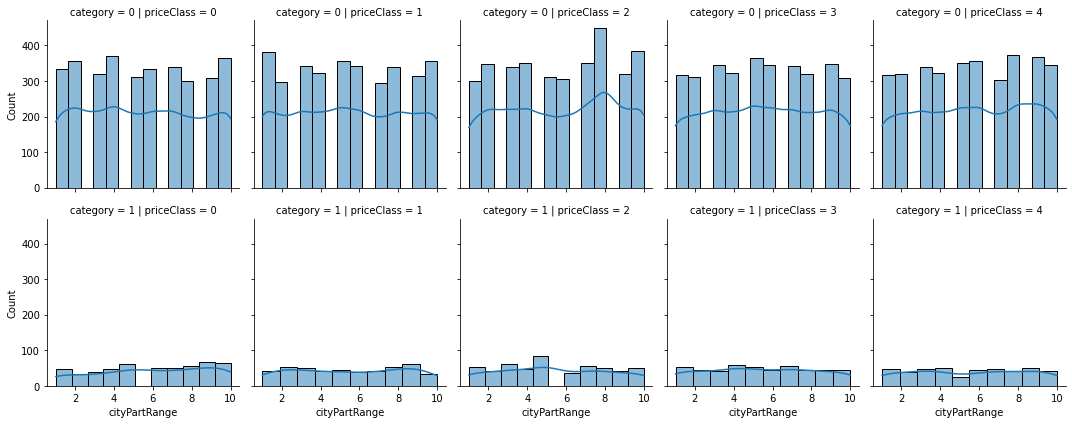

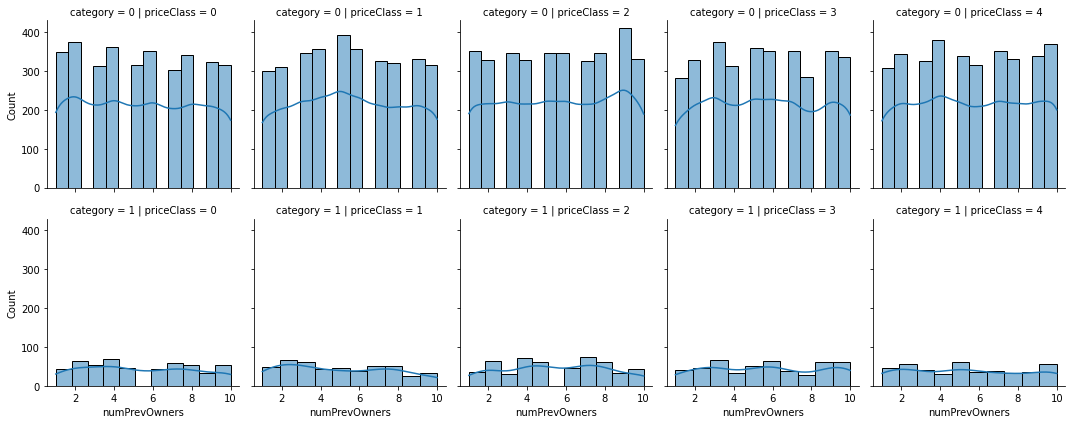

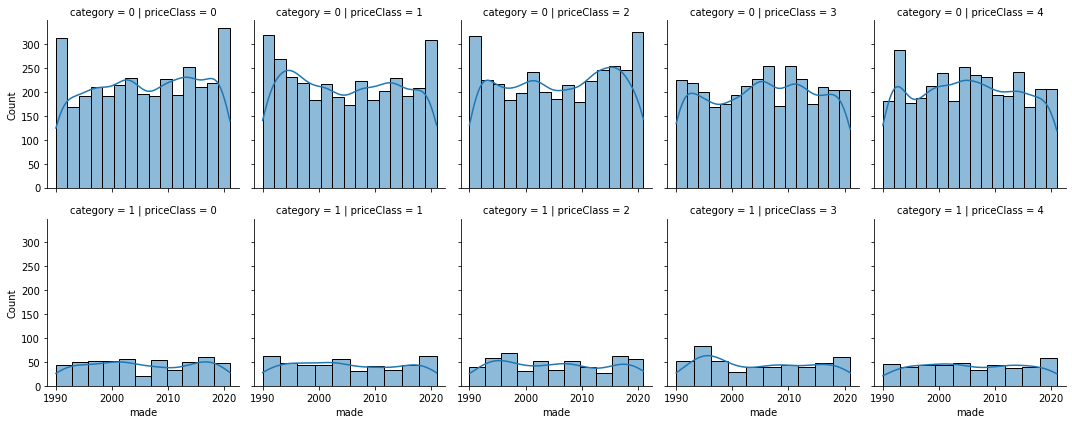

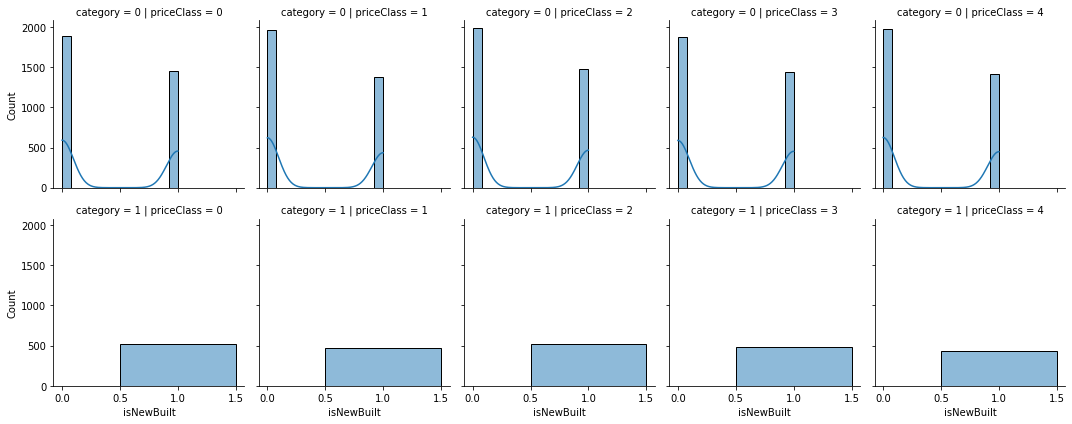

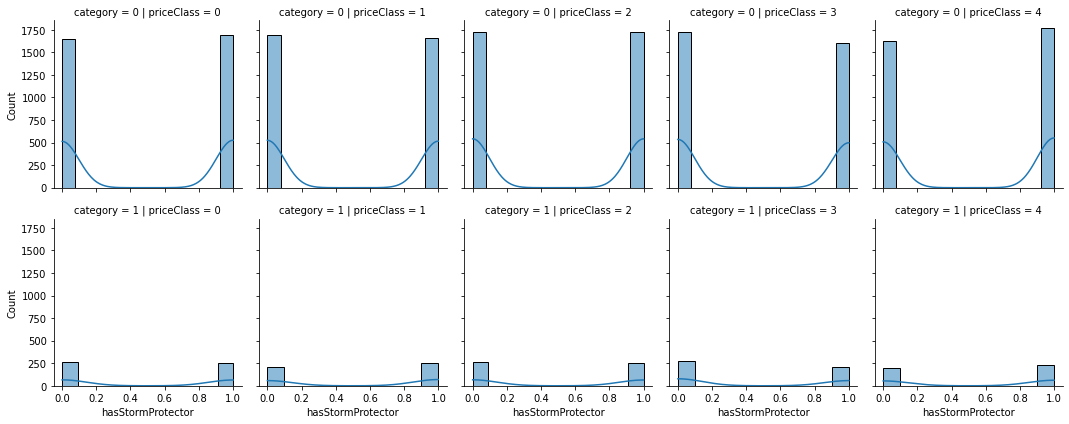

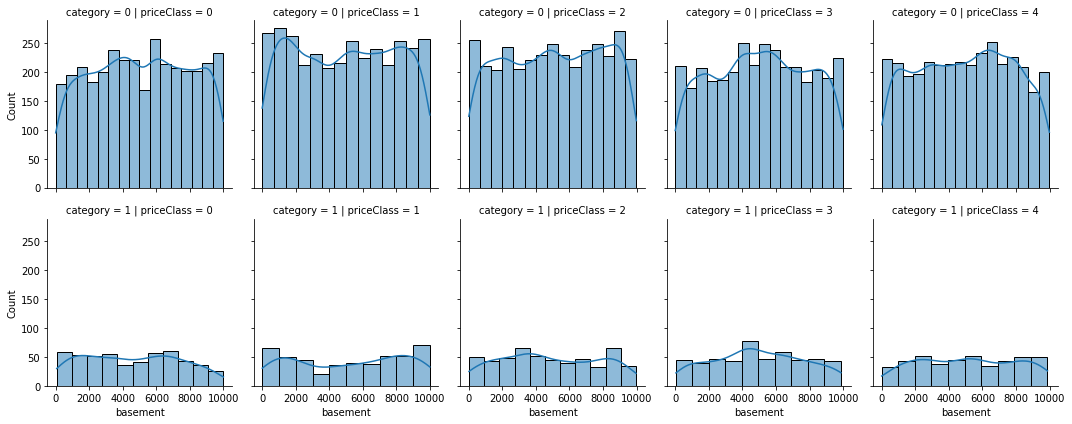

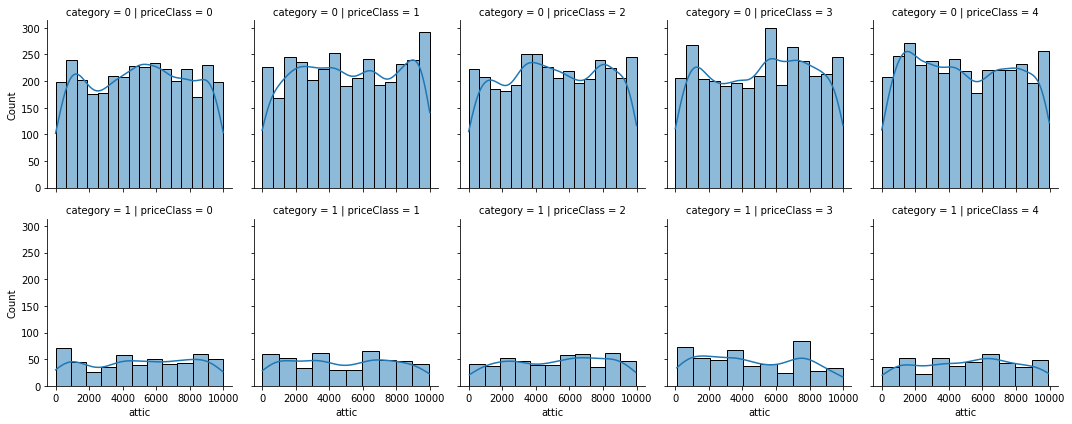

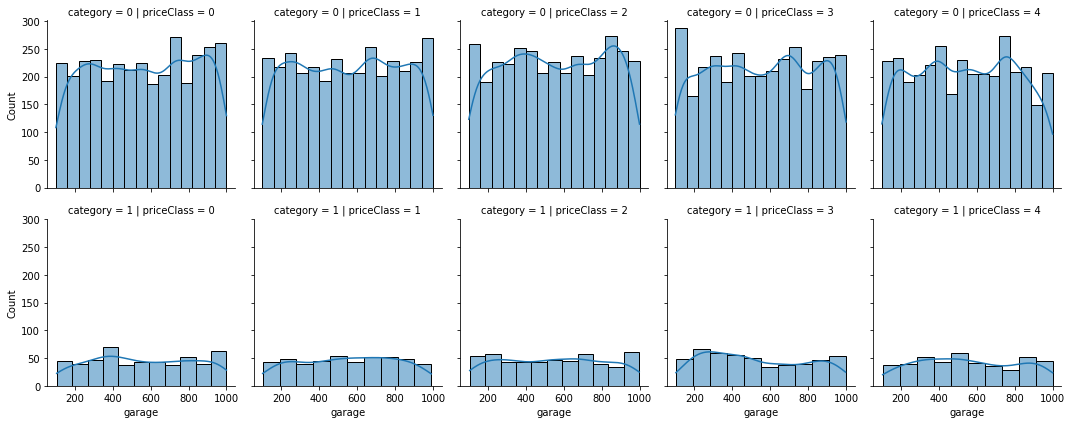

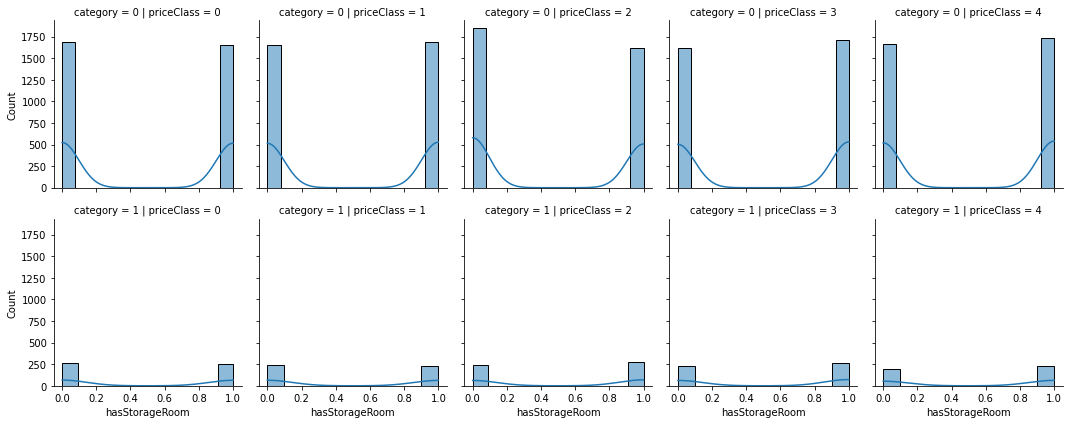

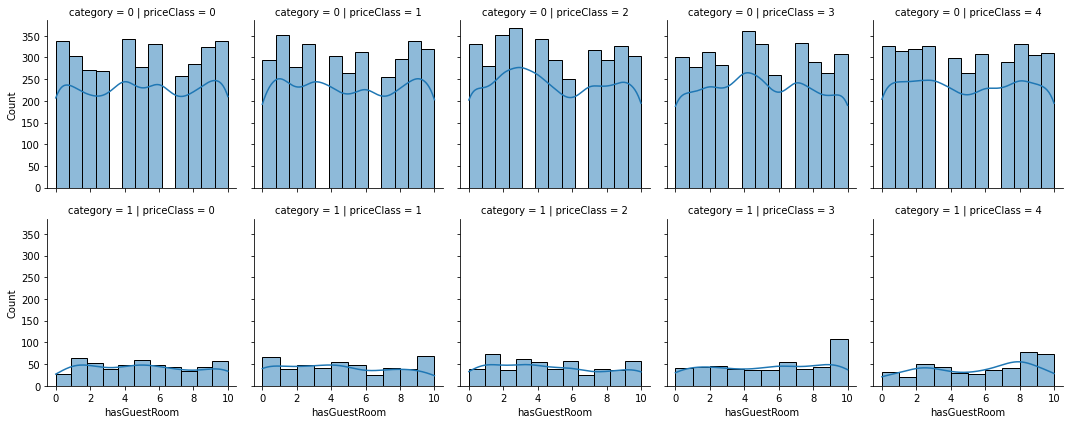

In [ ]:
# Checando a distribuição normal por meio dos histogramas
for col in data.columns[:-2]:
  g = sns.FacetGrid(data, col='priceClass', row='category')
  g= g.map(sns.histplot, col, kde=True)

In [ ]:
# Interquartil para encontrar outliers:

data_iqr = data.copy()
Q1 = data_iqr.quantile(0.25)
Q3 = data_iqr.quantile(0.75)
IQR = Q3 - Q1

for col in data_iqr.columns:
    Q1 = data_iqr[col].quantile(0.25)
    Q3 = data_iqr[col].quantile(0.75)
    IQR = Q3 - Q1
    iqr_outliers = data_iqr[(data_iqr[col] < (Q1 - 1.5*IQR)) | (data_iqr[col] > (Q3 + 1.5*IQR))]



In [ ]:
# Checando a quantidade de outliers por meio do Interquartil (linhas, coluna)
iqr_outliers.shape

(0, 18)

In [ ]:
# Z-score para encontrar outliers:
z_data = data.copy().apply(zscore)
z_data

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,category,priceClass
0,-0.715050,1.584595,0.996996,1.005096,-0.152660,-1.563426,-0.537914,1.228404,-1.674447,1.005200,0.999274,-1.123466,-1.601380,-0.529089,0.998963,-0.619287,2.640120,-0.706835
1,1.135374,-0.150147,-1.003013,-0.994930,0.194253,-0.852583,-0.537914,0.877587,0.695961,1.005200,0.999274,-0.369688,-0.178012,-1.271495,0.998963,-0.305345,-0.378771,1.420290
2,-1.264432,-1.711415,0.996996,-0.994930,-1.158708,1.209650,-0.537914,-0.876495,-0.489243,1.005200,-1.000726,0.945429,-0.413633,-0.974532,0.998963,-1.247171,-0.378771,-1.415877
3,0.672315,0.439665,0.996996,-0.994930,-0.742412,-0.218233,-0.189707,-0.876495,-1.135718,1.005200,0.999274,-0.173080,0.290128,-1.515156,-1.001038,-0.619287,-0.378771,0.711248
4,1.070648,-1.052213,0.996996,-0.994930,1.304375,0.511751,-0.886120,1.579220,0.372723,-0.994827,0.999274,-1.137360,-1.206957,-0.685185,-1.001038,0.950424,-0.378771,1.420290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19275,-0.156835,0.092717,0.996996,-0.994930,0.124871,-0.869176,1.203118,1.228404,-0.812480,-0.994827,0.999274,1.489400,-0.302023,1.085167,-1.001038,0.322540,-0.378771,0.002207
19276,1.537497,1.445816,-1.003013,-0.994930,0.922771,-0.166939,1.551325,-0.525679,0.372723,1.005200,0.999274,0.438974,-0.192136,-1.515156,0.998963,0.008598,-0.378771,1.420290
19277,1.230879,-0.080757,-1.003013,1.005096,-1.019943,0.991360,1.203118,-0.525679,-1.027972,1.005200,0.999274,-1.669173,-0.259653,-0.559547,-1.001038,0.008598,-0.378771,1.420290
19278,-0.553637,0.439665,0.996996,1.005096,1.685980,-1.045811,1.203118,-1.578129,-1.674447,1.005200,0.999274,1.019417,-0.750873,-0.445331,0.998963,-1.561113,2.640120,-0.706835


In [ ]:
# Checando a quantidade de outliers por meio do Z-score (linhas, coluna)
for col in z_data.columns:
  z_outliers = z_data[abs(z_data[col] > 3)]
  
z_outliers.shape

(0, 18)

In [ ]:
# Tabela com valores correspondentes do ks-test para cada variável:
kstest_list = [kstest(data[col], 'norm') for col in data.columns]
ks_table = pd.DataFrame(data=kstest_list, index=[data.columns],
                        columns=['KS-Test', 'P-value'])
ks_table

,KS-Test,P-value
squareMeters,1.000000,0.0
numberOfRooms,0.979615,0.0
hasYard,0.500000,0.0
hasPool,0.500000,0.0
floors,0.980082,0.0
cityCode,0.999896,0.0
cityPartRange,0.879065,0.0
numPrevOwners,0.884044,0.0
made,1.000000,0.0
isNewBuilt,0.500000,0.0


In [ ]:
#Tabela com a curtose de cada variável:
kurtosis_list = [kurtosis(data[col]) for col in data.columns]
k_table = pd.DataFrame(data=kurtosis_list, index=[data.columns],
                       columns=['Curtose'])
k_table

,Curtose
squareMeters,-1.184960
numberOfRooms,-1.184620
hasYard,-1.999964
hasPool,-1.999897
floors,-1.203639
cityCode,-1.223893
cityPartRange,-1.222100
numPrevOwners,-1.210418
made,-1.216614
isNewBuilt,-1.999892


In [ ]:
# Tabela com coeficiente de assimetria:
asymmetry_list = [skew(data[col]) for col in data.columns]
asymmetry_table = pd.DataFrame(data=asymmetry_list, index=[data.columns],
                               columns=['Coeficiente de assimetria'])
asymmetry_table

,Coeficiente de assimetria
squareMeters,0.001254
numberOfRooms,0.025779
hasYard,-0.006017
hasPool,0.010166
floors,0.006924
cityCode,-0.026721
cityPartRange,-0.016926
numPrevOwners,0.017006
made,-0.007230
isNewBuilt,0.010374


In [ ]:
# Tabela de frequência da variável categórica 'category':

basic_freq = data['category'].value_counts()[0]/len(data)
luxury_freq = data['category'].value_counts()[1]/len(data)
category_freq = pd.DataFrame(data=[basic_freq, luxury_freq, 1],
                             index=['Basic:', 'Luxury:', 'Total:'],
                             columns= ['Frequência'])

category_freq

,Frequência
Basic:,0.874533
Luxury:,0.125467
Total:,1.000000


In [ ]:
# Tabela de frequência da variável categórica 'priceClass':
freq = [(data['priceClass'].value_counts()[n])/len(data) for n in sorted(data.iloc[:,-1].unique())]
freq.append(1)
priceClass_freq = pd.DataFrame(data=freq,
                               index=['Very low:', 'Low:', 'Medium:',
                                      'High:', 'Very High:', 'Total:'],
                               columns=['Frequência'])

priceClass_freq

,Frequência
Very low:,0.200000
Low:,0.197666
Medium:,0.206224
High:,0.197666
Very High:,0.198444
Total:,1.000000


In [ ]:
# Descrição estatística das variáveis que abrangem o dataset:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
squareMeters,19280.0,49915.359907,28753.080416,111.0,25299.00,50118.0,74875.0,99999.0
numberOfRooms,19280.0,50.327645,28.823470,1.0,25.00,50.0,75.0,100.0
hasYard,19280.0,0.501504,0.500011,0.0,0.00,1.0,1.0,1.0
hasPool,19280.0,0.497459,0.500007,0.0,0.00,0.0,1.0,1.0
floors,19280.0,50.400519,28.826405,1.0,26.00,50.0,76.0,100.0
cityCode,19280.0,50279.354927,29049.368214,3.0,24489.00,50880.0,75723.0,99953.0
cityPartRange,19280.0,5.544813,2.871934,1.0,3.00,6.0,8.0,10.0
numPrevOwners,19280.0,5.498444,2.850567,1.0,3.00,5.0,8.0,10.0
made,19280.0,2005.540716,9.281345,1990.0,1997.00,2006.0,2014.0,2021.0
isNewBuilt,19280.0,0.497407,0.500006,0.0,0.00,0.0,1.0,1.0


In [ ]:
# Coeficiente de variação de cada coluna (std(col) / mean(col): 
cv = [data[col].std()/data[col].mean() for col in data.columns]
cv_table = pd.DataFrame(data=cv, index=data.columns, columns=['Coeficiente de Variação'])
cv_table

,Coeficiente de Variação
squareMeters,0.576037
numberOfRooms,0.572716
hasYard,0.997022
hasPool,1.005122
floors,0.571947
cityCode,0.577759
cityPartRange,0.517950
numPrevOwners,0.518432
made,0.004628
isNewBuilt,1.005226


In [ ]:
# Matriz de correlação
data.corr(method='pearson')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,category,priceClass
squareMeters,1.000000,-0.003351,-0.006408,-0.010902,-0.001715,-0.003351,0.008128,0.018541,-0.009506,-0.009486,0.006960,-0.003492,-0.011790,-0.021563,0.011338,0.001567,-0.009998,0.979117
numberOfRooms,-0.003351,1.000000,-0.002541,-0.001229,0.027961,0.007621,0.001507,0.018978,0.004022,-0.003722,-0.008443,-0.008391,0.018146,0.023102,-0.011800,-0.027858,-0.001964,-0.002719
hasYard,-0.006408,-0.002541,1.000000,0.018480,0.001542,0.012530,0.001777,0.006388,-0.013113,-0.017308,-0.013903,-0.011359,-0.009972,0.000612,-0.011103,-0.009353,0.377633,-0.009923
hasPool,-0.010902,-0.001229,0.018480,1.000000,-0.011730,0.013111,0.017978,-0.018253,-0.000559,0.005057,0.003738,0.003099,-0.016045,0.000007,0.019196,-0.008446,0.380701,-0.014648
floors,-0.001715,0.027961,0.001542,-0.011730,1.000000,0.014022,-0.008279,0.005960,0.002809,0.011257,0.003819,0.013459,-0.010004,0.009389,0.003023,-0.025032,-0.000542,-0.000418
cityCode,-0.003351,0.007621,0.012530,0.013111,0.014022,1.000000,0.012167,-0.009896,0.005729,-0.010271,0.005917,0.009131,0.007971,0.008321,-0.012658,-0.001785,0.003992,-0.002024
cityPartRange,0.008128,0.001507,0.001777,0.017978,-0.008279,0.012167,1.000000,0.011217,0.009861,0.000587,-0.003136,-0.007035,0.005222,-0.004023,-0.002364,-0.011756,0.001859,0.007577
numPrevOwners,0.018541,0.018978,0.006388,-0.018253,0.005960,-0.009896,0.011217,1.000000,0.025945,-0.014705,0.005223,0.012926,0.006316,0.018467,0.034500,-0.021398,-0.014927,0.021106
made,-0.009506,0.004022,-0.013113,-0.000559,0.002809,0.005729,0.009861,0.025945,1.000000,-0.014345,0.009732,0.008494,0.011807,-0.000380,-0.004011,-0.009045,-0.008756,-0.010990
isNewBuilt,-0.009486,-0.003722,-0.017308,0.005057,0.011257,-0.010271,0.000587,-0.014705,-0.014345,1.000000,-0.000515,-0.015640,0.018551,0.007939,0.007889,0.033174,0.380740,-0.008911


In [ ]:
# Identificando os valores de p para cada variável independente
for col in data.columns[:-1]:
  model = ols('priceClass ~ {}'.format(col), data = data).fit()
  print(sm.stats.anova_lm(model, typ=2))
  print('-----------------------------------------------------------')

                    sum_sq       df              F  PR(>F)
squareMeters  36764.794675      1.0  447156.714902     0.0
Residual       1585.018603  19278.0            NaN     NaN
-----------------------------------------------------------
                     sum_sq       df         F    PR(>F)
numberOfRooms      0.283615      1.0  0.142571  0.705743
Residual       38349.529663  19278.0       NaN       NaN
-----------------------------------------------------------
                sum_sq       df         F    PR(>F)
hasYard       3.776101      1.0  1.898388  0.168275
Residual  38346.037177  19278.0       NaN       NaN
-----------------------------------------------------------
                sum_sq       df         F    PR(>F)
hasPool       8.228784      1.0  4.137401  0.041959
Residual  38341.584494  19278.0       NaN       NaN
-----------------------------------------------------------
                sum_sq       df         F    PR(>F)
floors        0.006714      1.0  0.003375  0.953

In [ ]:
# Se valor p < 5% --> rejeito H0 / p > 5% --> aceito H0: 
# Menores que 5%: squareMeters, hasPool, numPrevOwners, garage, category  (Rejeita H0) (discriminam)
# Maiores que 5%: numberOfRooms, hasYard, floors, cityCode, cityPartRange, made, isNewBuilt, hasStormProtector, basement, attic, hasStorageRoom, hasGuestRoom

In [ ]:
# Checando potencial de multicolinearidade:
# squareMeters x hasPool: -0.010902 -> muito fraca
# squareMeters x numPrevOwners: 0.018541 -> muito fraca
# squareMeters x garage: -0.021563 -> muito fraca
# squareMeters x category: -0.009998	-> muito fraca

# hasPool x numPrevOwners: -0.018253 -> muito fraca
# hasPool x garage: 0.000007 -> muito fraca
# hasPool x category: 0.380701 -> fraca

# numPrevOwners x garage: 0.018467 -> muito fraca
# numPrevOwners x category: -0.014927 -> muito fraca

# garage x category: -0.008480 -> muito fraca

In [ ]:
# Definindo o target e as variáveis independentes que entrarão no modelo:
target = pd.array(data['priceClass'].copy())
ind_variables = pd.DataFrame(data=data.copy(), columns=['squareMeters', 'hasPool', 'numPrevOwners', 'garage', 'category'])

In [ ]:
# Criação do modelo e apuração de métricas(Acerto e Matriz de confusão):
x_train, x_test, y_train, y_test = train_test_split(ind_variables, target, test_size=0.2)
modelo_lda = LinearDiscriminantAnalysis()
modelo_lda.fit(x_train, y_train)

y_pred = modelo_lda.predict(x_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
print('Acerto: ', accuracy)
print('-----------------------------')
cm = metrics.confusion_matrix(y_test, y_pred)
print('Matriz de confusão:\n', cm)

Acerto:  0.991701244813278
-----------------------------
Matriz de confusão:
 [[740   0   0   0   0]
 [  1 732   2   0   0]
 [  0   7 805   2   0]
 [  0   0  11 771   8]
 [  0   0   0   1 776]]


In [ ]:
# Normalizando os dados para o KNN:

def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

normalized_data = normalize(data.iloc[:,:-1].copy())

In [ ]:
# Selecionando target e variáveis independentes para o modelo:
data['priceClass'] = data['priceClass'].replace({0:'very_low', 1: 'low',
                                                 2: 'medium', 3: 'high',
                                                 4: 'very_high'})


knn_target = data['priceClass']
knn_variables = normalized_data.iloc[:, :-1]

In [ ]:
# Treinando e criando o modelo KNN, utilizando o k default do sklearn = 5 
x_train, x_test, y_train, y_test = train_test_split(knn_variables, knn_target, test_size=0.2)
modelo_knn = KNeighborsClassifier(metric='euclidean')
modelo_knn.fit(x_train, y_train)

y_pred = modelo_knn.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Acerto: ', accuracy)
print('-----------------------------')
cm = metrics.confusion_matrix(y_test, y_pred)
print('Matriz de confusão:\n', cm)

Acerto:  0.6190352697095436
-----------------------------
Matriz de confusão:
 [[486  56 123  94   3]
 [ 58 496 101   9  84]
 [165 129 454  38  32]
 [190  19  72 455   0]
 [ 17 199  79   1 496]]


In [ ]:
# KNN com as variáveis selecionadas na análise discriminante que possui um fitting melhor com a dependente:

knn_target2 = data['priceClass']
knn_variables2 = pd.DataFrame(data=normalized_data.copy(), columns=['squareMeters', 'hasPool', 'numPrevOwners', 'garage', 'category'])
x_train, x_test, y_train, y_test = train_test_split(knn_variables2, knn_target2, test_size=0.2)
modelo_knn = KNeighborsClassifier(metric='euclidean')
modelo_knn.fit(x_train, y_train)

y_pred = modelo_knn.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Acerto: ', accuracy)
print('-----------------------------')
cm = metrics.confusion_matrix(y_test, y_pred)
print('Matriz de confusão:\n', cm)


Acerto:  0.9434647302904564
-----------------------------
Matriz de confusão:
 [[679   0  22  18   0]
 [  0 697  28   0  25]
 [ 30  38 741   0   0]
 [ 32   0   0 739   0]
 [  0  25   0   0 782]]


In [ ]:
# Utilizando outra z-score e o valor k como a raiz da quantidade total de valores y de treino = 124

knn_zvariables = z_data.iloc[:, :-1]
x_train, x_test, y_train, y_test = train_test_split(knn_variables, knn_target, test_size=0.2)
modelo_knn = KNeighborsClassifier(n_neighbors=124,metric='euclidean')
modelo_knn.fit(x_train, y_train)

y_pred = modelo_knn.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Acerto: ', accuracy)
print('-----------------------------')
cm = metrics.confusion_matrix(y_test, y_pred)
print('Matriz de confusão:\n', cm)

Acerto:  0.4846991701244813
-----------------------------
Matriz de confusão:
 [[328  34 222 177   2]
 [ 46 312 230   2 184]
 [213 134 364  43  53]
 [244   1  99 424   0]
 [  6 212  85   0 441]]


In [ ]:
# Separação da variável independente e variáveis dependentes para o modelo Random Forest:
rf_target = data['priceClass']
rf_variables = data.iloc[:, :-1]

In [ ]:
# Treinando, criando o modelo e apurando sua acurácia:
x_train, x_test, y_train, y_test = train_test_split(rf_variables, rf_target, test_size=0.2)
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
print('Acerto: ', accuracy)

Acerto:  0.9997406639004149


In [ ]:
# Separação e treino das variáveis para o modelo Decision Tree:
dt_target = data['priceClass']
dt_variables = data.iloc[:, :-1]
x_train, x_test, y_train, y_test = train_test_split(dt_variables, dt_target, test_size=0.2)


In [ ]:
# Criando e apurando tanto a acurácia do modelo quando sua matriz de confusão:
tree_model = DecisionTreeClassifier(criterion='entropy')
tree_model.fit(x_train, y_train)

y_pred = tree_model.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Acerto: ', accuracy)
print('-----------------------------')
cm = metrics.confusion_matrix(y_test, y_pred)
print('Matriz de confusão:\n', cm)

Acerto:  0.9997406639004149
-----------------------------
Matriz de confusão:
 [[797   0   0   0   0]
 [  0 731   0   0   0]
 [  0   0 790   0   0]
 [  1   0   0 763   0]
 [  0   0   0   0 774]]


[Text(1178.0, 1494.8999999999999, 'squareMeters <= 59982.5\nentropy = 2.322\nsamples = 15424\nvalue = [3014, 3080, 3186, 3062, 3082]'),
 Text(620.0, 1223.1, 'squareMeters <= 40000.5\nentropy = 1.585\nsamples = 9346\nvalue = [0, 3080, 3184, 0, 3082]'),
 Text(248.0, 951.3, 'squareMeters <= 20001.5\nentropy = 1.0\nsamples = 6155\nvalue = [0, 3073, 0, 0, 3082]'),
 Text(124.0, 679.4999999999999, 'entropy = 0.0\nsamples = 3080\nvalue = [0, 0, 0, 0, 3080]'),
 Text(372.0, 679.4999999999999, 'squareMeters <= 20023.0\nentropy = 0.008\nsamples = 3075\nvalue = [0, 3073, 0, 0, 2]'),
 Text(248.0, 407.6999999999998, 'numPrevOwners <= 5.5\nentropy = 0.863\nsamples = 7\nvalue = [0, 5, 0, 0, 2]'),
 Text(124.0, 135.89999999999986, 'entropy = 0.0\nsamples = 2\nvalue = [0, 0, 0, 0, 2]'),
 Text(372.0, 135.89999999999986, 'entropy = 0.0\nsamples = 5\nvalue = [0, 5, 0, 0, 0]'),
 Text(496.0, 407.6999999999998, 'entropy = 0.0\nsamples = 3068\nvalue = [0, 3068, 0, 0, 0]'),
 Text(992.0, 951.3, 'squareMeters <= 40

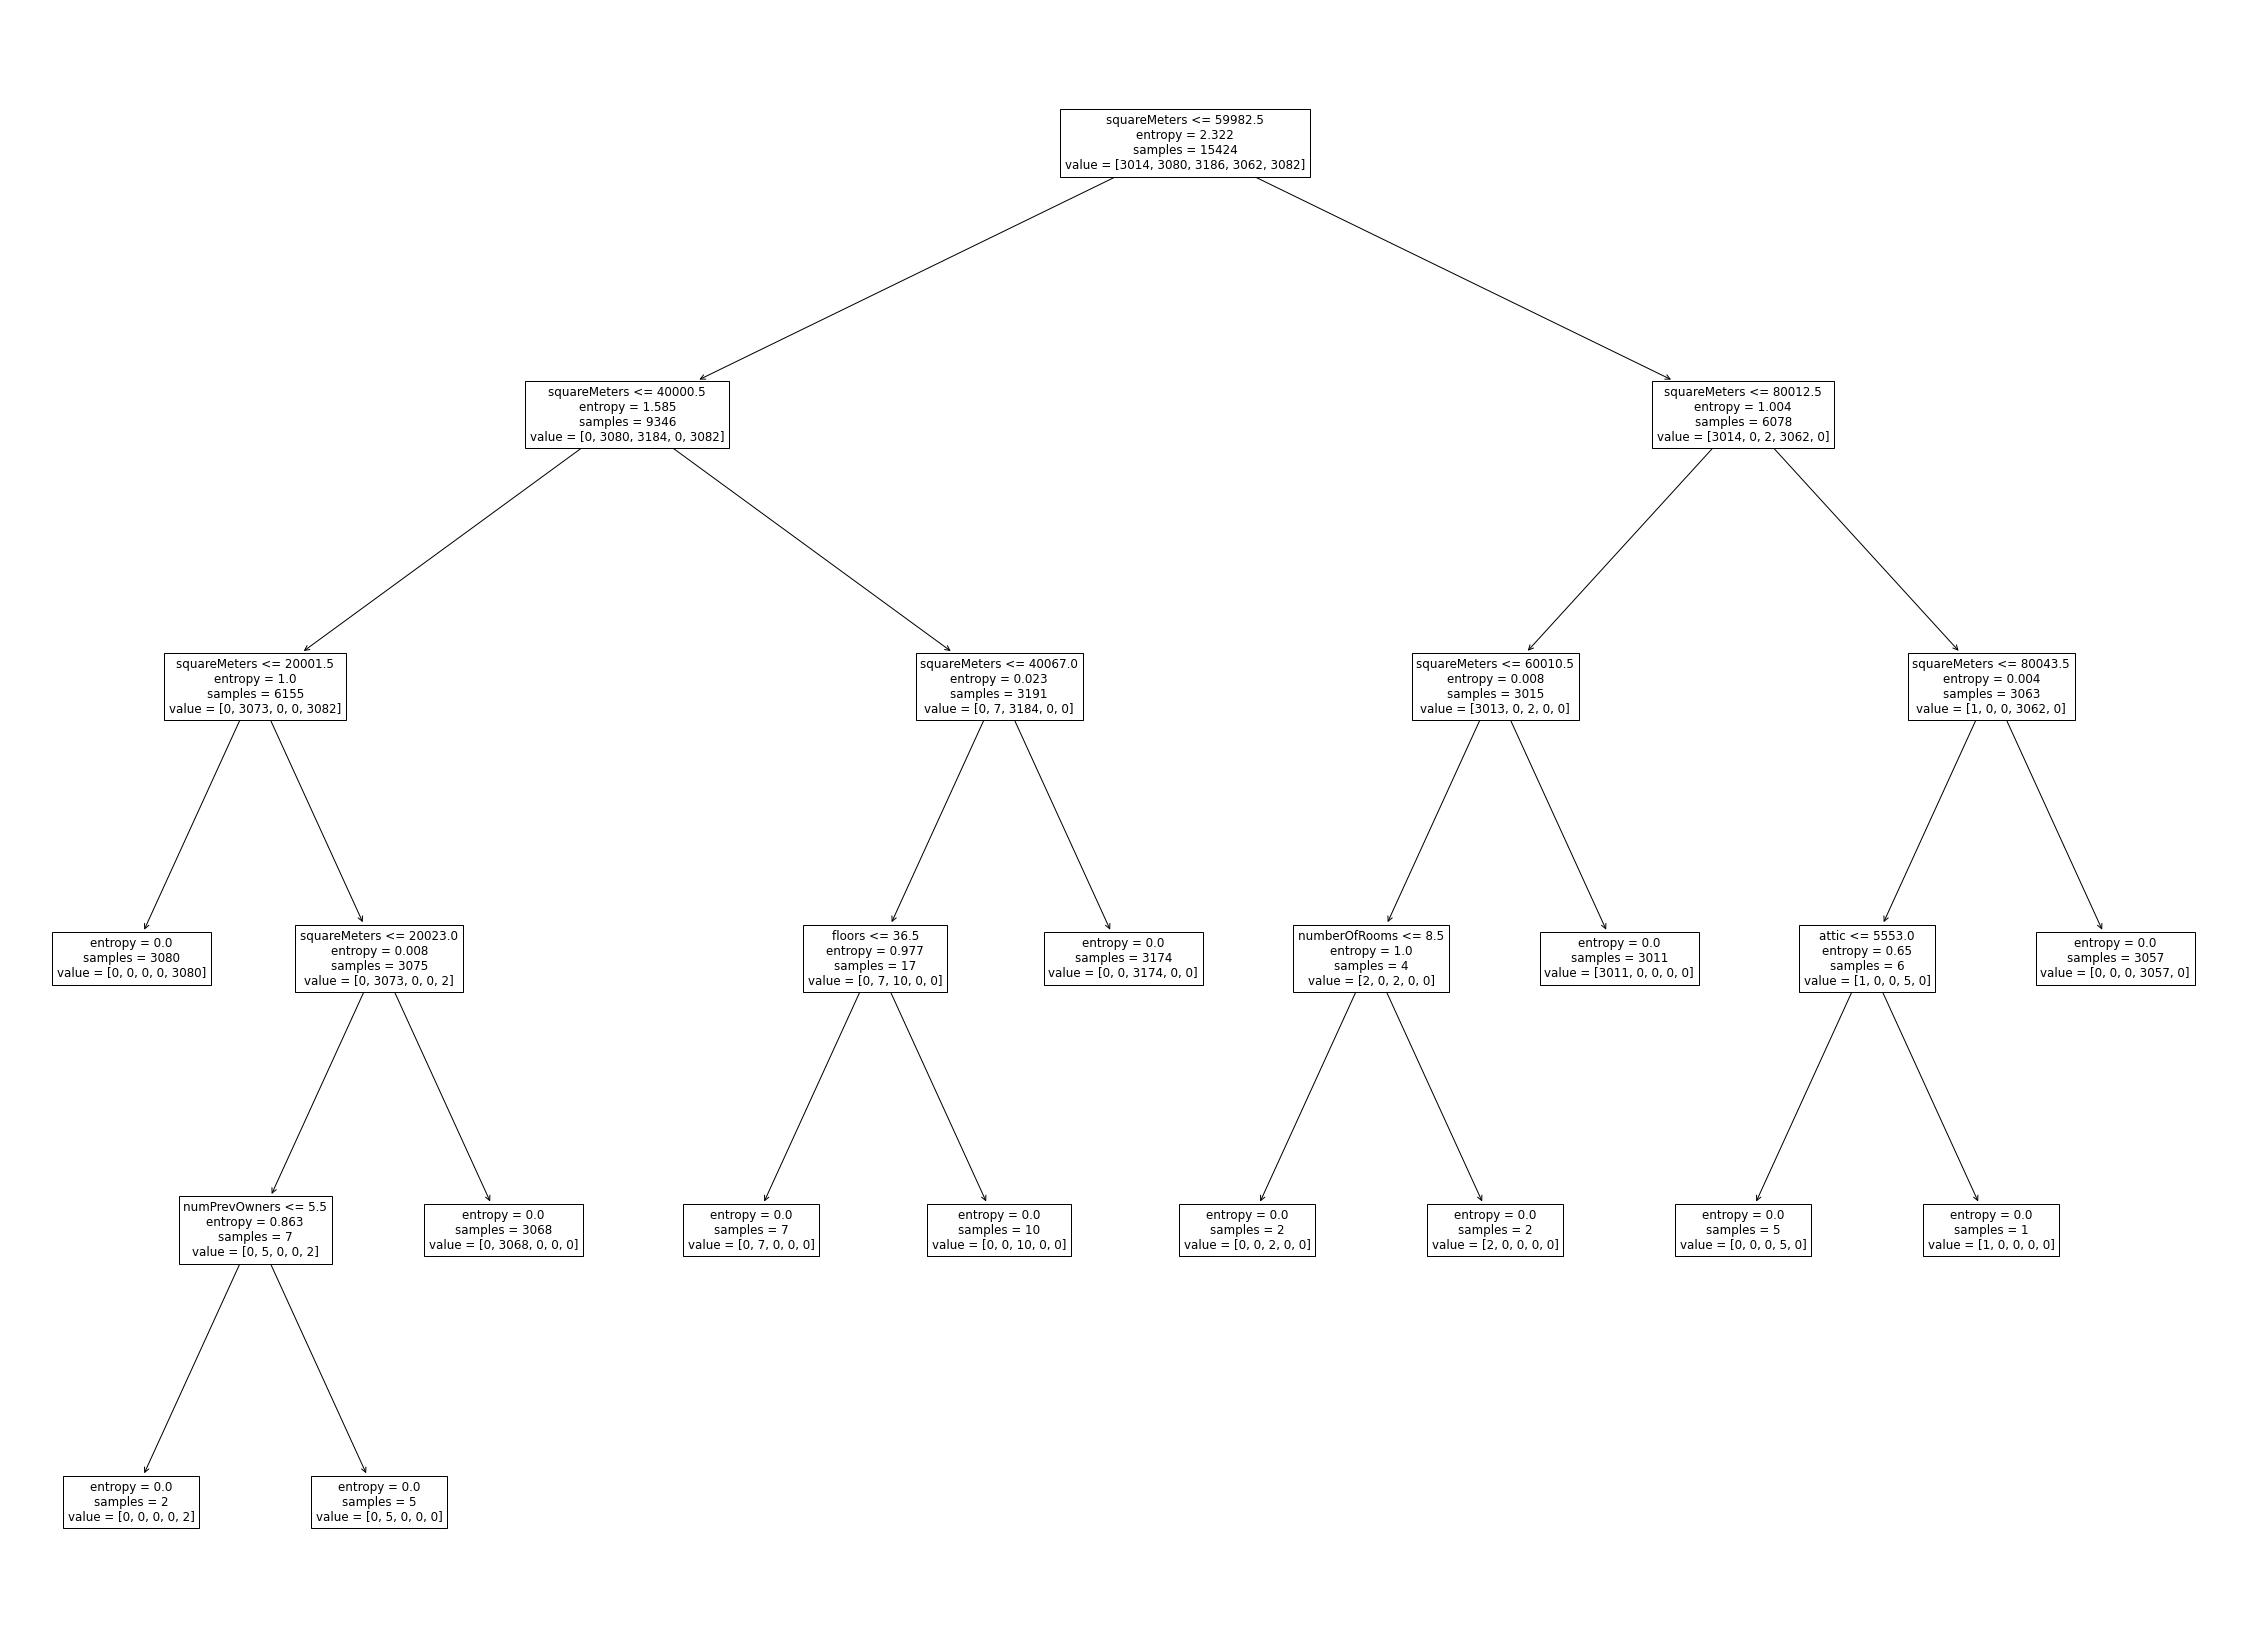

In [ ]:
# Plotando a árvore de decisão:
pylab.figure(figsize=(40,30))
plot_tree(tree_model, feature_names= dt_variables.columns)